In [1]:
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import argparse
import statsmodels.api as sm


Loading files

In [2]:
paths = glob.glob(os.path.join("E:/Turku_collab/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(*paths, sep='\n')
cell_info = (pd.read_csv("E:/Turku_collab/lunagel_50s/remodelling/cell_info.csv")).drop(columns=['Unnamed: 0'])

E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodellin

In [3]:
df_list = []
data =[]
for i in paths:
    data = pd.read_csv(i)     
    parts = i.split('\\') 
    data['incubation_set'] = parts[1]
    data['incubation'] = parts[2]
    data['experiment'] = parts[3].split('_')[0]
#   data['date'] = parts[3].split('_')[1]
    data['sample'] = parts[4].split('_')[-1]
    
    max_location = data['location'].unique().max()
    
    # condition = (data['incubation_set'] == "48_144") & (data['experiment'] == 1)
    # if len(data.loc[condition]) > 0:
    #     data = data[~((data['location'] == 1))]  # This removes rows with location == 1
    #     data = data[~((data['location'] == 2))]  
    #     # Shift the location column by 1 lower for the remaining data
    #     data.loc[condition, 'location'] -= 2

    for j, location in enumerate(data['location'].unique()):
        # Use .loc to properly assign values to the dataframe
        data.loc[data['location'] == location, 'gradient'] = data['y'] + location*665.6
        data.loc[data['location'] == location, 'gradient_inverse'] = data['y'] + (max_location-location)*665.6
    
    # data = data[~((data['gradient'] < 500))]  
    # data = data[~((data['gradient_inverse'] < 500))]  
    
    df_list.append(data)

    # print(i)
    # print( parts[1],parts[2],parts[3].split('_')[0],parts[4].split('_')[-1])


df = pd.concat(df_list, ignore_index=True)
df['gradient_direction'] = np.where(
    ((df['sample'] == "MDAMB231") & (df['day'] == "241107")) | 
    (df['day'].isin(["241122","241125","241121","241126"])),
    "stiff_to_soft",
    "soft_to_stiff"
)



Generating file with beads close-by to cells (6h movement = 664 µm radius)

In [70]:
time = 180 #min
speed = 0.5 # or 0.6µm/min
pixel_size = 0.325 #µm
distance = time*speed/pixel_size
print(distance)

276.9230769230769


In [71]:
grouped_all = df.groupby(['day', 'sample', 'holder', 'location'])
grouped_cell = cell_info.groupby(['day', 'sample', 'holder', 'location'])
closeby = []
faraway = []
#looping through groups in both files
for key_all,j_all in grouped_all:
    for key_cell, j_cell in grouped_cell:
        #check if the groups match
        if key_all == key_cell:
            # Each bead of the group and comparing to the distance to each cell
            for index_all, row_all in j_all.iterrows():
                for index_all, row_all in j_all.iterrows():
                    bead_classified = False  # Flag to track if bead is classified
                    for index_cell, row_cell in j_cell.iterrows():
                        if ((row_cell['x'] - distance) < row_all['x'] < (row_cell['x'] + distance)) and \
                        ((row_cell['y'] - distance) < row_all['y'] < (row_cell['y'] + distance)):
                            closeby.append(row_all)
                            bead_classified = True
                            break  # Exit loop once bead is classified as closeby
                    if not bead_classified:
                        faraway.append(row_all)
final_closeby = pd.DataFrame(closeby)
final_faraway = pd.DataFrame(faraway)

print(final_closeby.shape)
print(final_faraway.shape)

(2582, 32)
(1877, 32)


Saving files

In [72]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'

#Data_all and data_cell-closeby-beads including gradient direction
df.to_csv(saving_path+'/gradients.csv')  
final_closeby.to_csv(saving_path+'/gradients_closeby.csv') 
final_faraway.to_csv(saving_path+'/gradients_faraway.csv') 



Loading files

In [73]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
download_closeby = pd.read_csv(saving_path +'/gradients_closeby.csv', index_col=None)
download_faraway = pd.read_csv(saving_path +'/gradients_faraway.csv', index_col=None)



## GLS model

In [63]:
alpha = 0.05
def GLS_g(data,ax, color):
    x= data['gradient'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    #print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions
    y_predictedGLS = np.exp(y_predictedGLS_log)  # Transform back from log scale

    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI,
                         #color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


In [64]:
from scipy.optimize import curve_fit

def fitting(ax,x_data, y_data,color_type,marker_type):
    
    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    k_guess = 0.1  # initial slope estimate, a smaller value usually works
    L_guess = np.max(y_data) 
    k_guess = 0.1
    x0_guess = 2500
    params, _ = curve_fit(logistic_func, x_data, y_data,p0=[L_guess, k_guess, x0_guess], maxfev=10000)
    L, k, x0 = params

    # Display the fitted parameters
    print(f'Fitted parameters: L = {L:.3f}, k = {k:.3f}, x0 = {x0:.3f}')

    # Plot the data and the fitted logistic curve
    ax.scatter(x_data, y_data, label='Data', s=35,c=color_type, marker=marker_type)
    #ax.plot(x_data, logistic_func(x_data, *params), label=f'Logistic fit: L={L:.3f}, k={k:.3f}, x0={x0:.3f}', color=color_type)



Plotting G

Kernel Ridge Regression

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel(x, y, ax, color_type, marker_type,alpha):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped)  # Standardize x data
    # Note: We don't scale y, since it's already a scalar
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color_type, marker=marker_type)

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color_type, label='Kernel Fit', linewidth=3)






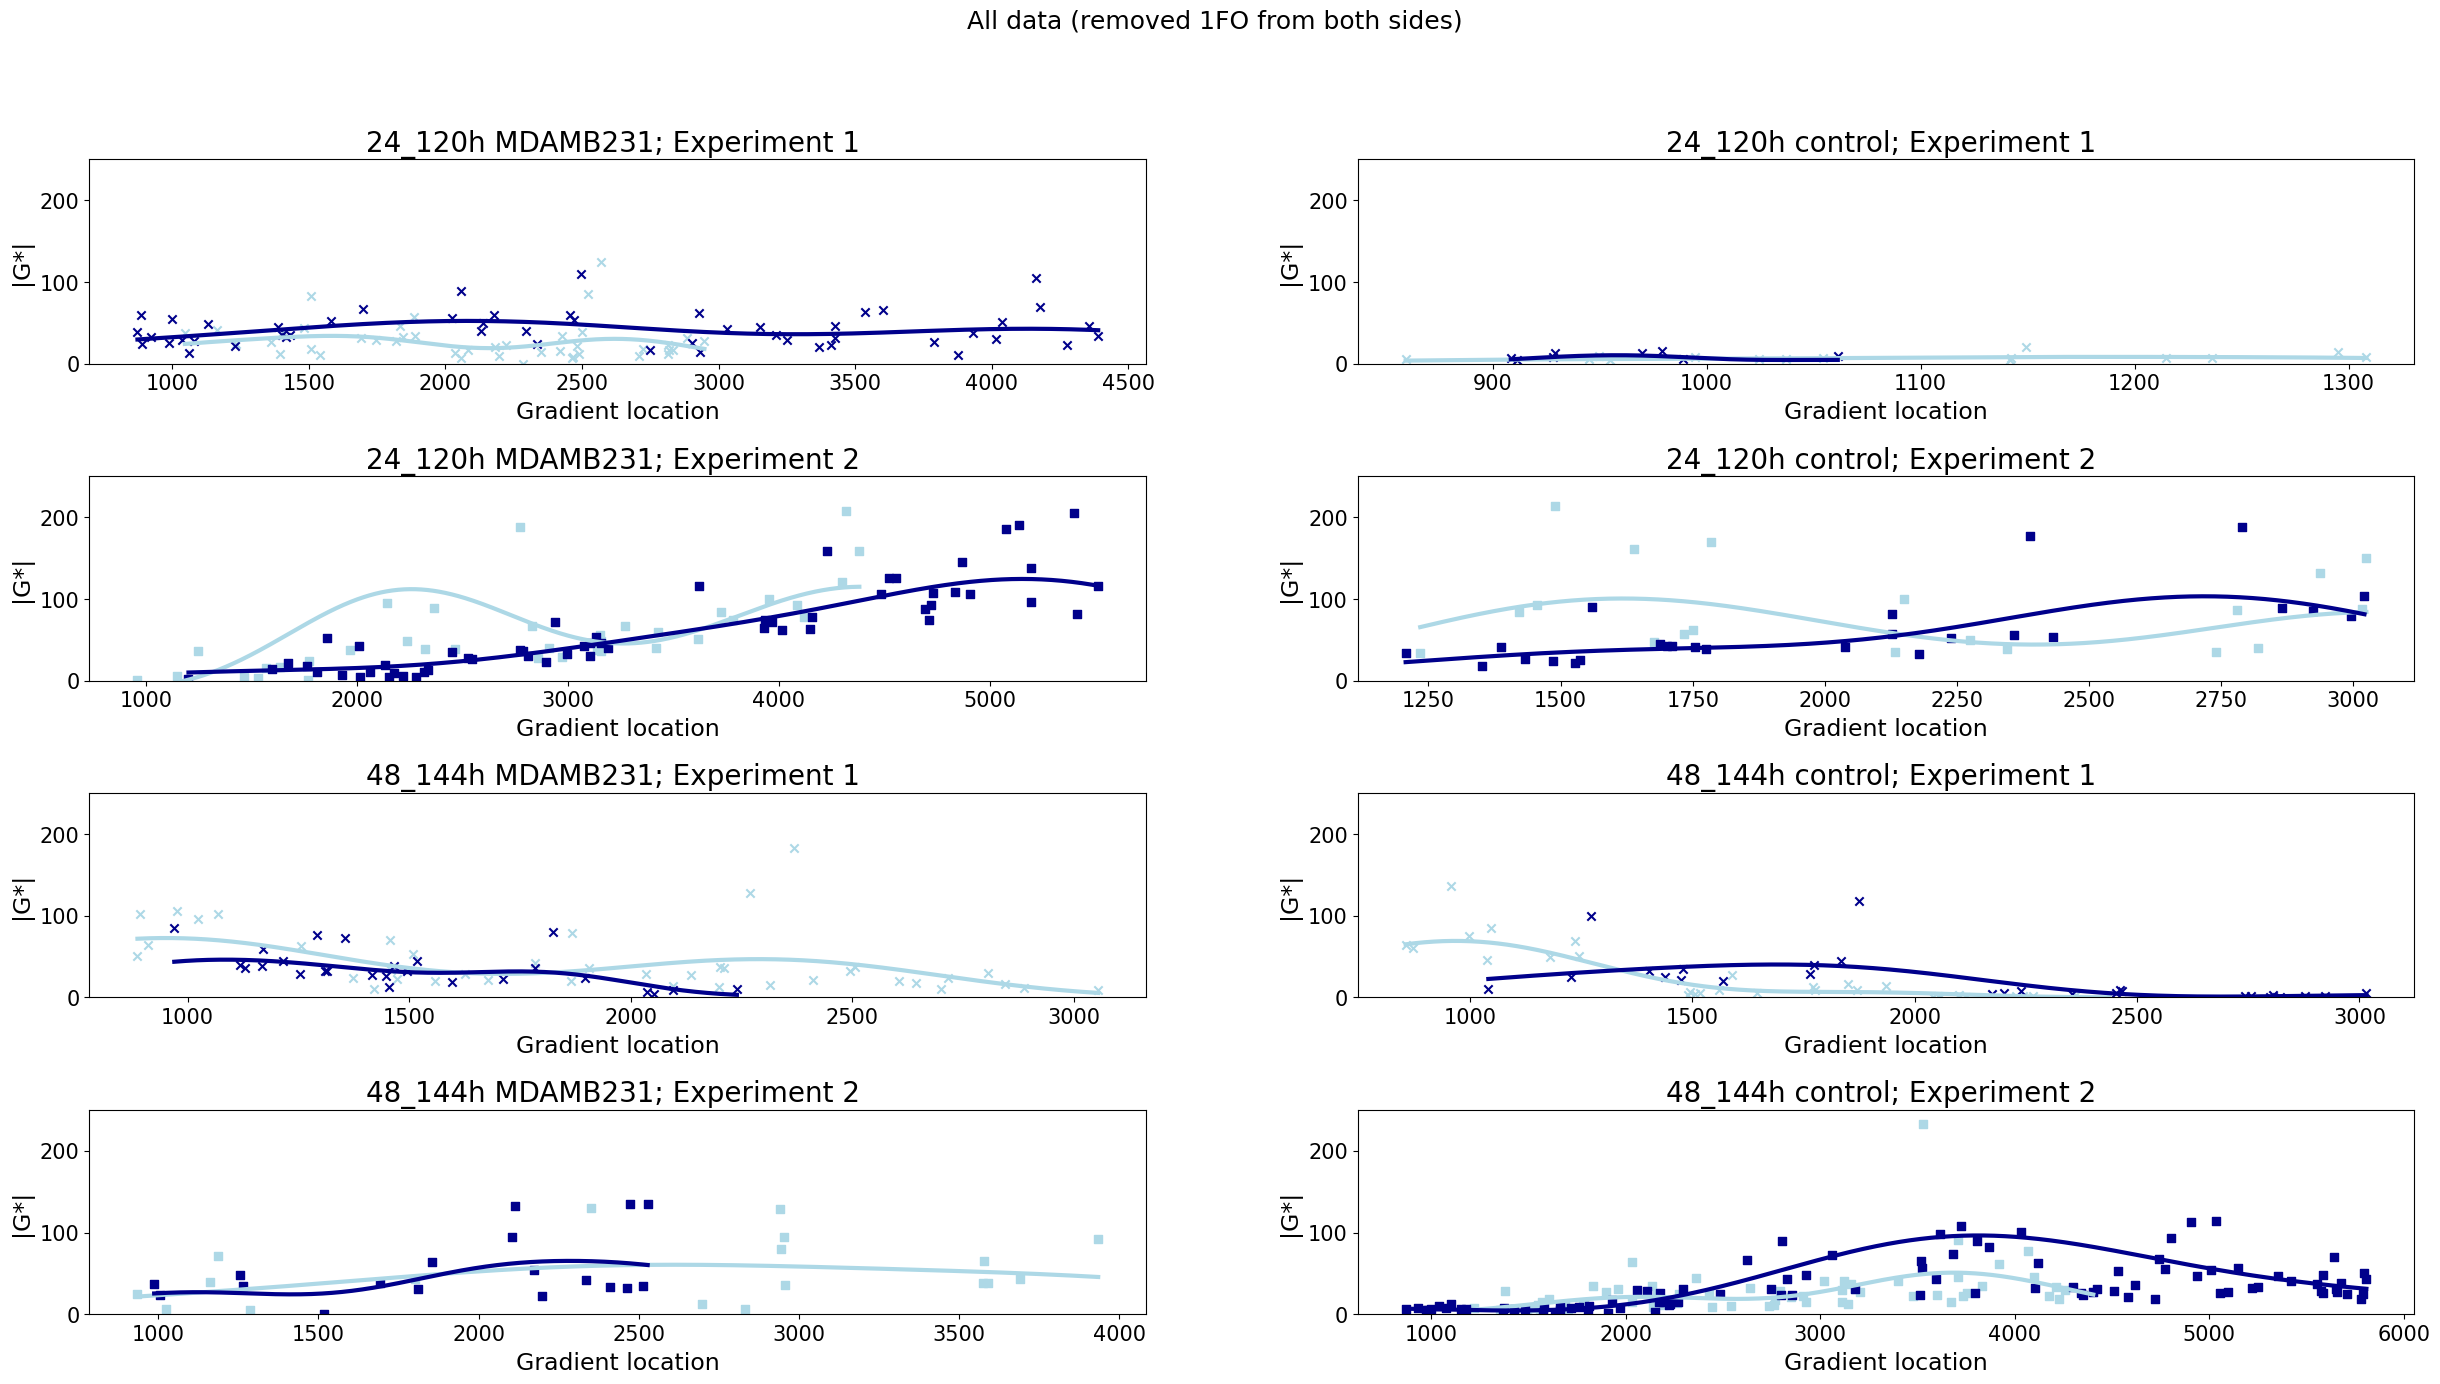

In [88]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("All data (removed 1FO from both sides)", fontsize=18)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
    
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[int(l)]
            row = (i*2)+(k)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]                

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    filtered_data = fourth[(fourth['gradient'] > fourth['gradient'].min()+800) & (fourth['gradient'] < fourth['gradient'].max()-800)]
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(filtered_data['gradient'],filtered_data['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    filtered_data = fourth[(fourth['gradient_inverse'] > fourth['gradient_inverse'].min()+800) & (fourth['gradient_inverse'] < fourth['gradient_inverse'].max()-800)]

                    fitting_kernel(filtered_data['gradient_inverse'],filtered_data['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o}; Experiment {k+1} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                
                ax.set_ylim (0,250) 
                #ax.set_xlim (0,5000)  
                

Plotting CLOSBY

In [67]:
print(final_closeby.head())
print(final_faraway.head())

        day    sample  holder  location  track_id  reference_id  distance(um)  \
230  241107  MDAMB231       1         1         0      7.000000    178.340079   
231  241107  MDAMB231       1         1         1      3.000000    119.719131   
232  241107  MDAMB231       1         1         2      8.000000    230.583528   
233  241107  MDAMB231       1         1         3      3.666667    166.305903   
234  241107  MDAMB231       1         1         4      6.666667    150.619592   

      Cov_Sum    a_(um)  phi_(rad)  ...           y  repeat  phi_(deg)  \
230  0.000086  0.120122   0.053687  ...   27.780231     1.0   3.076045   
231  0.000723  0.041040   0.023896  ...  108.486144     1.0   1.369139   
232  0.000566  0.067026   0.235411  ...   93.216930     1.0  13.488060   
233  0.000242  0.079859   0.024116  ...   69.616457     1.0   1.381746   
234  0.000168  0.096757   0.039051  ...  129.515290     1.0   2.237439   

      tan_phi  incubation_set  incubation  experiment    gradient  \

In [54]:
final_closeby.shape

(5213, 32)

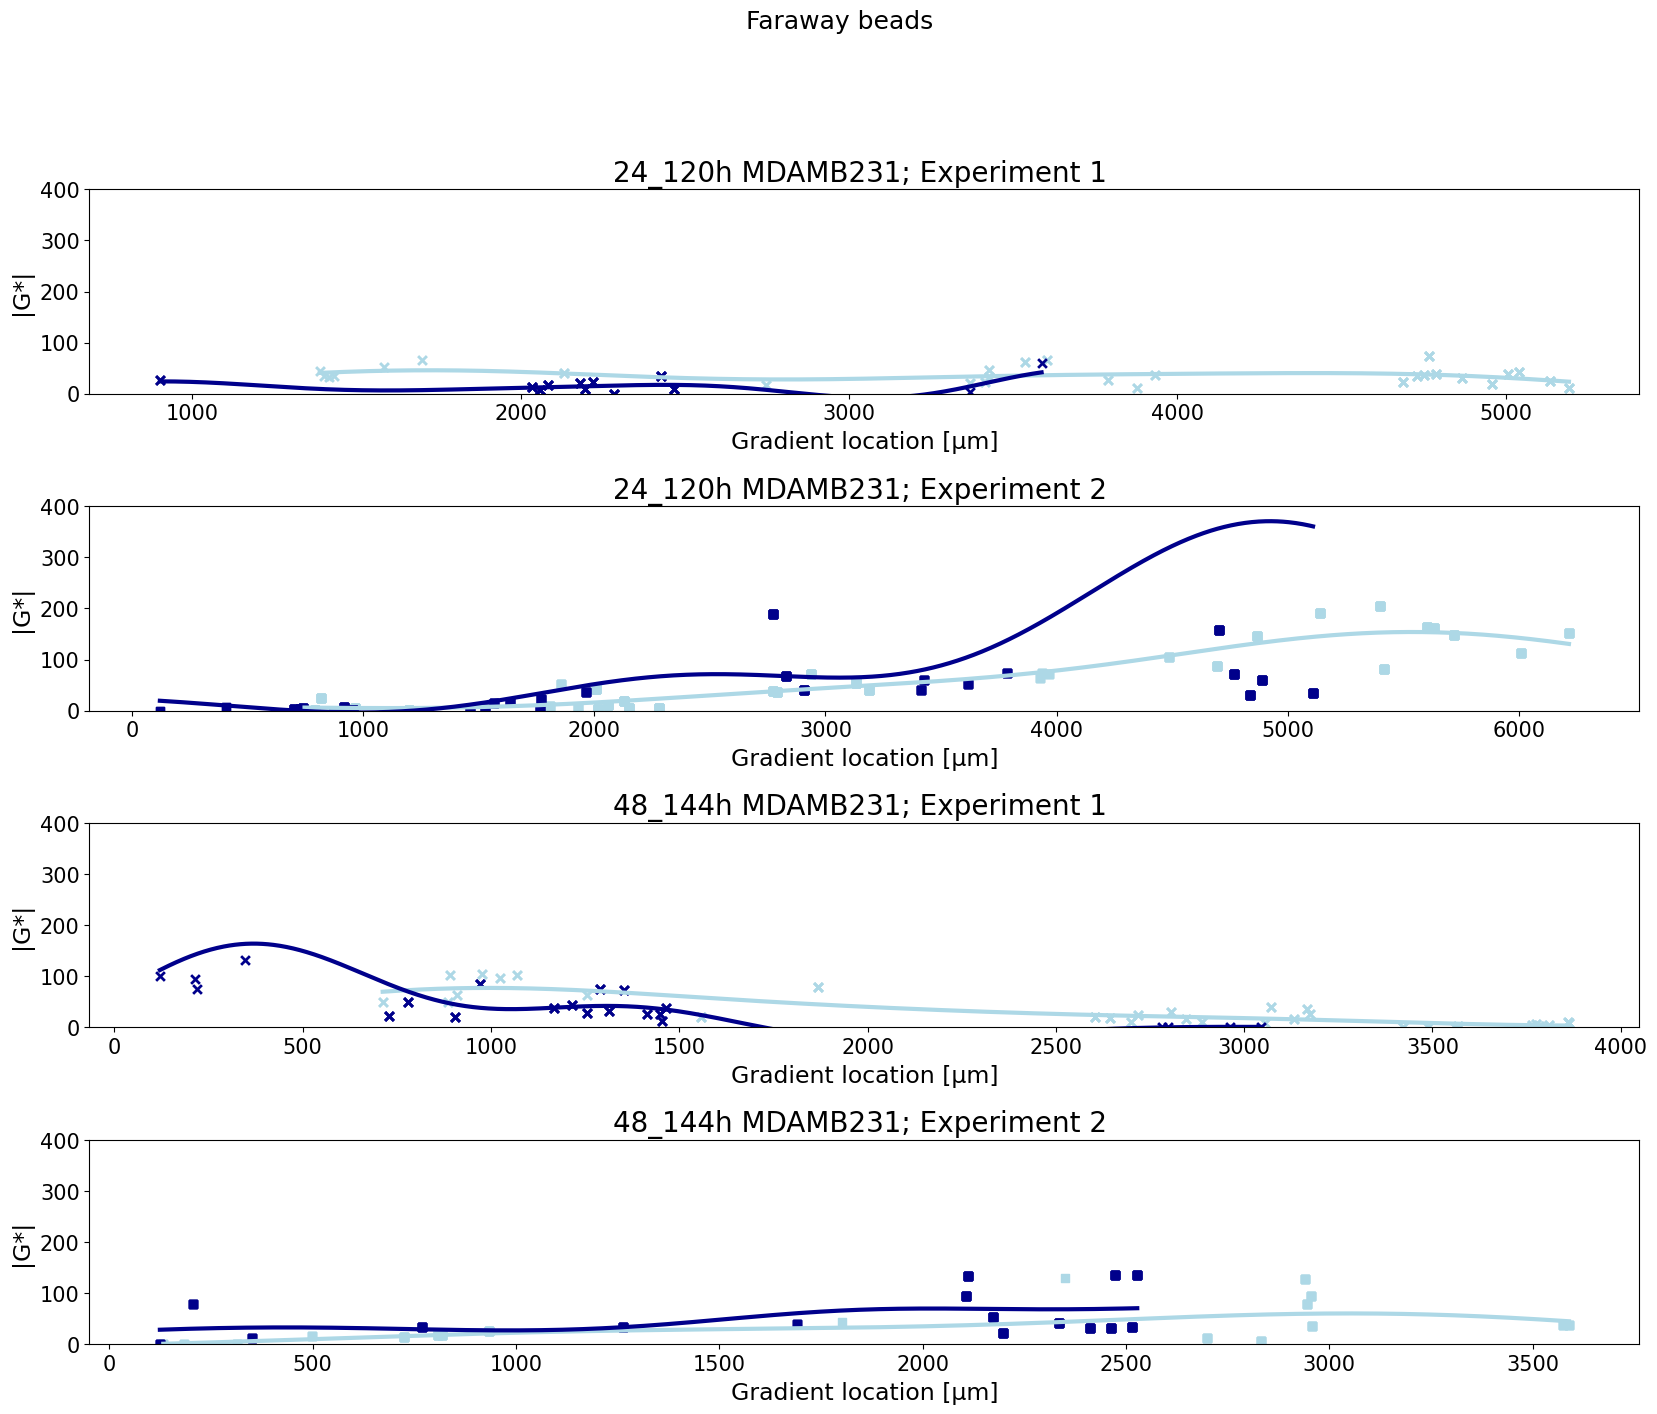

In [81]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("Faraway beads", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]
first = []

for i,j in enumerate(final_faraway['incubation_set'].unique()):
    first = final_faraway[final_faraway['incubation_set']==j]
    
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)
        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            
            marker_type = markers[int(l)]
            row = (i*2)+(k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                fourth = third[third['sample']==o]
                #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row]
                #GLS_g(dfffff,ax,color)

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location [µm]", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o}; Experiment {k+1} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                
                ax.set_ylim (0,400) 
                #ax.set_xlim (0,5000)  
  
                


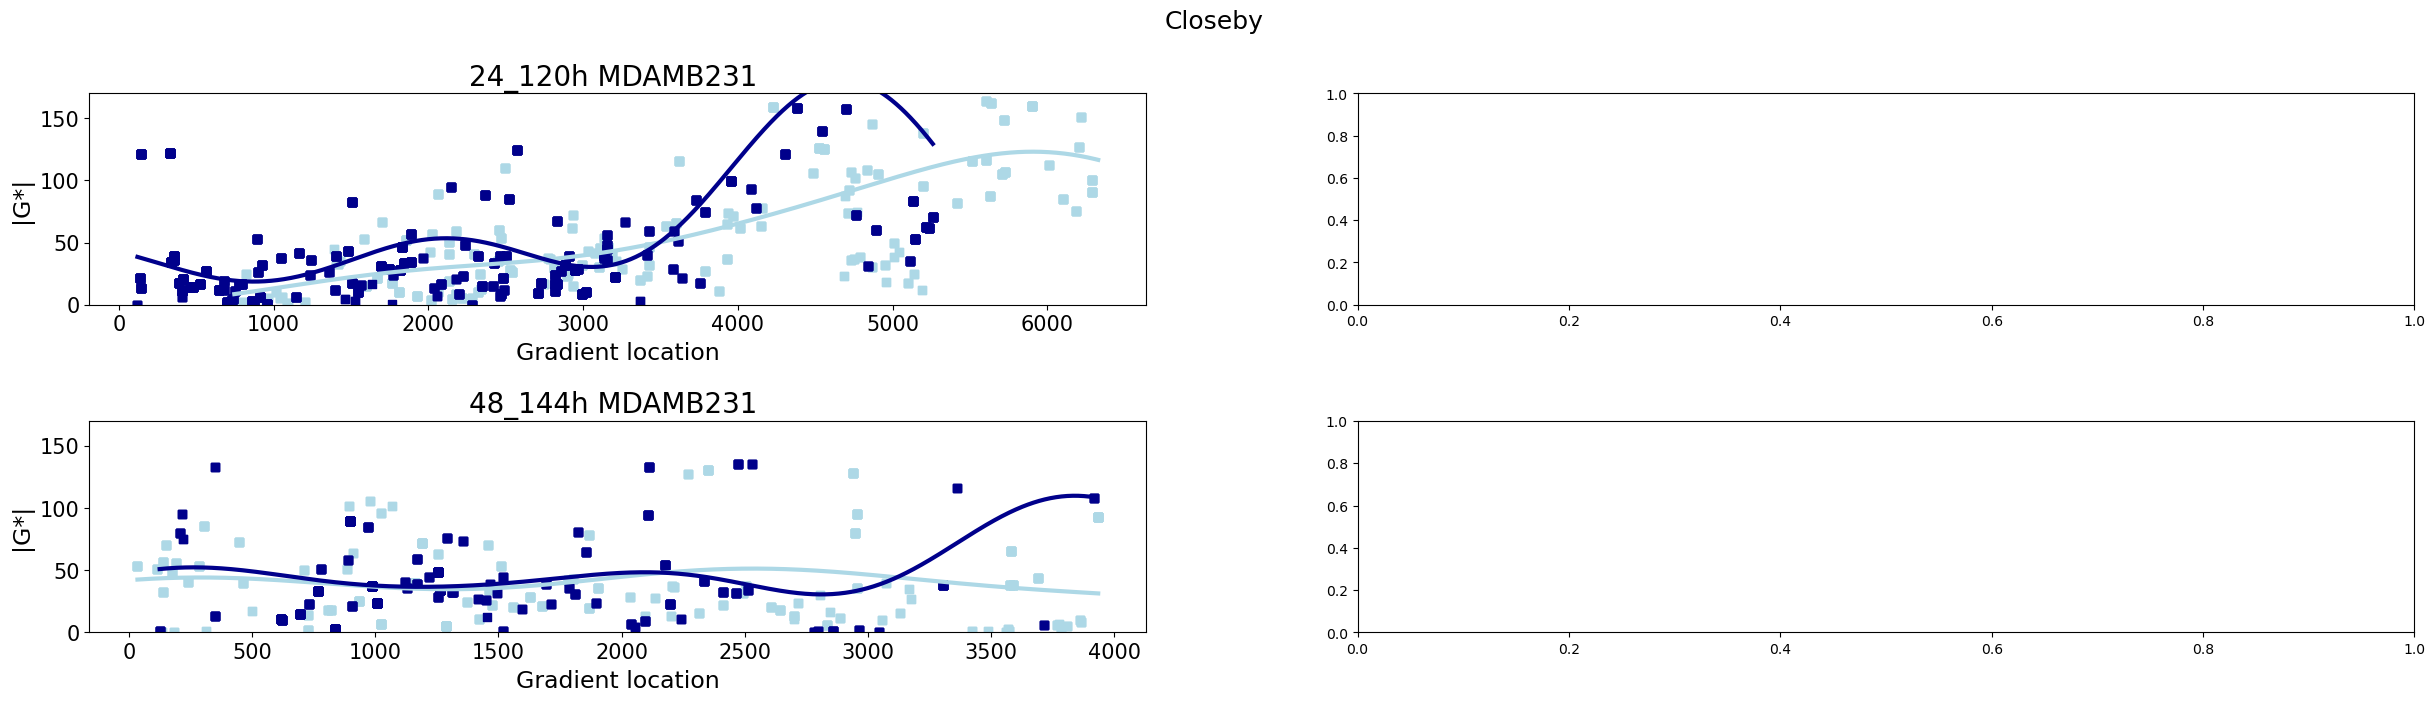

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("Closeby", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download_closeby['incubation_set'].unique()):
    first = download_closeby[download_closeby['incubation_set']==j]
    row = i
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        # for k,l in enumerate(second['experiment'].unique()):
        #     third = second[second['experiment']==l]
        #     marker_type = markers[l]
        #     row = (i*2)+(k)
        #     #print(l, marker_type)
        
        for m,o in enumerate(second['sample'].unique()):
            column = 0 if o=='MDAMB231' else 1
            fourth = second[second['sample']==o]
            #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
            date_value = str(fourth['day'].unique()[0])
            ax = axs[row,column]
            #GLS_g(dfffff,ax,color)

            if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
                
            else:
                #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,10)

            ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
            ax.set_title(f"{j}h {o} ", fontsize = 20)
            ax.tick_params(axis='both', labelsize=15)
            
            ax.set_ylim (0,170) 
            #ax.set_xlim (0,5000)  
  
                

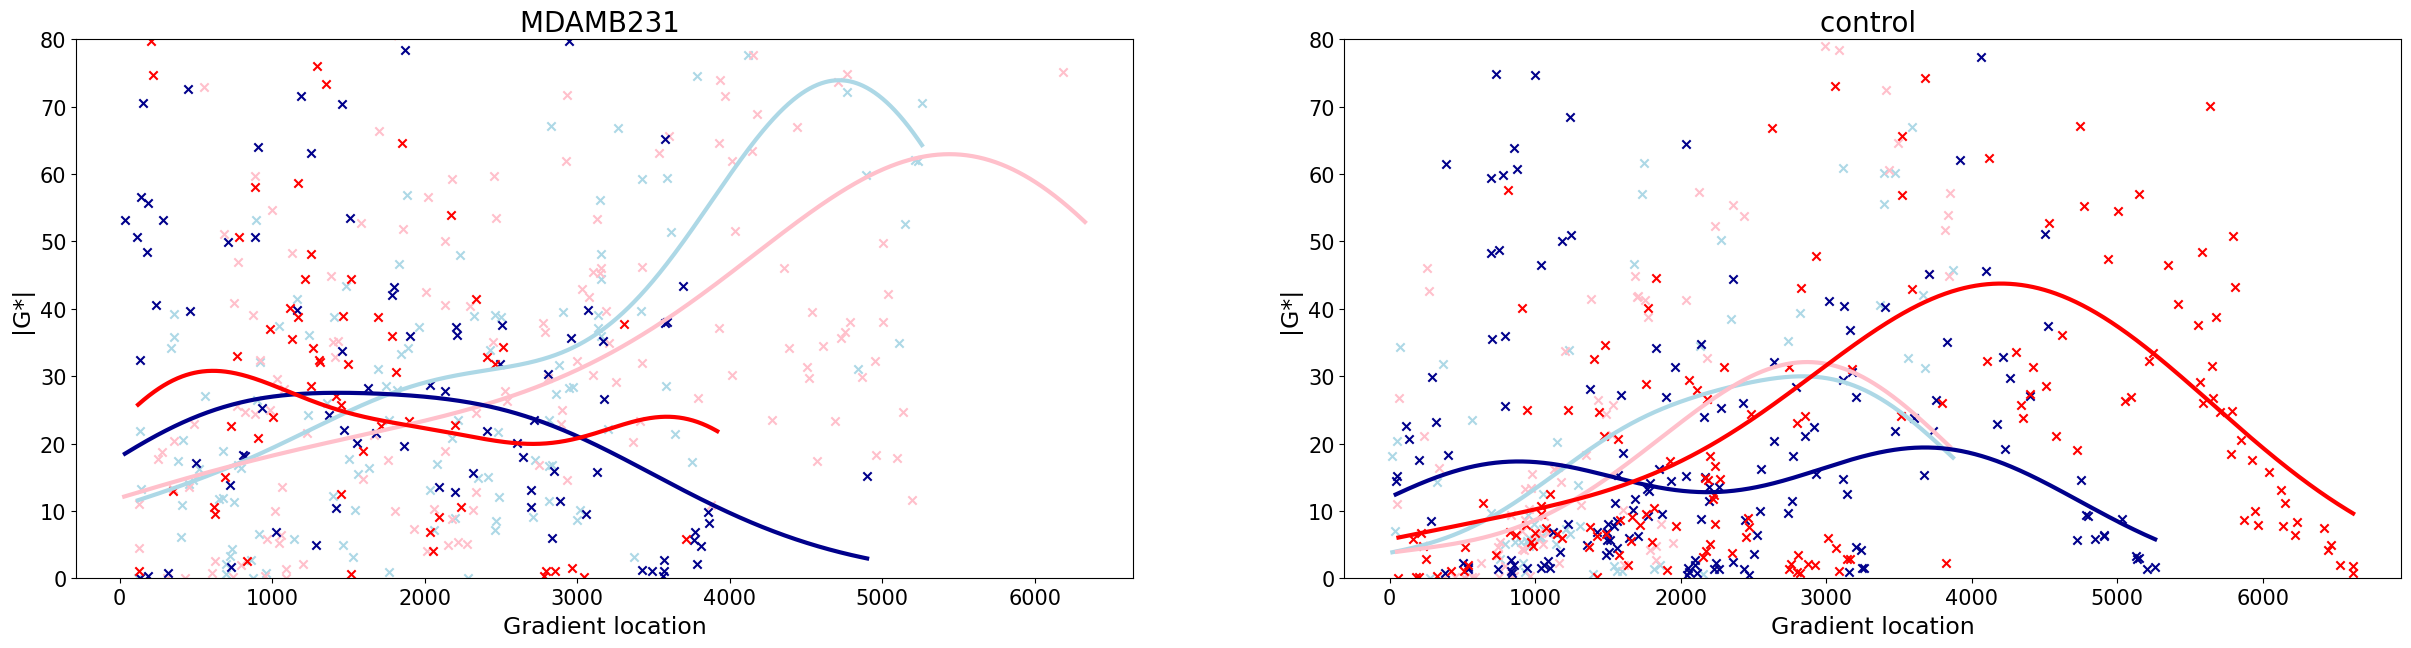

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","pink","darkblue","red"]

# for i,j in enumerate(download['incubation_set'].unique()):
#     first = download[download['incubation_set']==j]
#     row = i
        
for nn,n in enumerate(download['incubation'].unique()):
    second = download[download['incubation']==n]
    color_type = colors[int(nn)]
    #print(n, color)

    
    # for k,l in enumerate(second['experiment'].unique()):
    #     third = second[second['experiment']==l]
    #     marker_type = markers[l]
    #     row = (i*2)+(k)
    #     #print(l, marker_type)
    
    for m,o in enumerate(second['sample'].unique()):
        column = 0 if o=='MDAMB231' else 1
        fourth = second[second['sample']==o]
        #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
        date_value = str(fourth['day'].unique()[0])
        ax = axs[column]
        #GLS_g(dfffff,ax,color)

        if (fourth['gradient_direction'] == 'stiff_to_soft').all():
            #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
            # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
            #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
            fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
            
        else:
            #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
            fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type, 30)

        ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
        ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
        ax.set_title(f"{o} ", fontsize = 20)
        ax.tick_params(axis='both', labelsize=15)
        
        ax.set_ylim (0,80) 
        #ax.set_xlim (0,5000)  
  
                

## GLS phase shift

In [89]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha = 0.05

def GLS_phaseshift(data, ax, color):
    # Check for NaNs or infs in input data
    if data['f'].isnull().any() or data['phi_(rad)'].isnull().any():
        print("Data contains NaN values, which might cause issues.")
        return

    if (data['phi_(rad)'] <= 0).any():
        print("Data contains non-positive values in 'phi_(rad)', which will cause issues with log transformation.")
        return

    # Extract x and log-transform y
    x = data['f'].values.reshape(-1, 1)
    y = np.log(data['phi_(rad)'].values)

    # Fit GLS model
    x_const = sm.add_constant(x)
    modelGLS = sm.GLS(y, x_const)
    resultsGSL = modelGLS.fit()

    # Generate predictions
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)
    y_predictedGLS = np.exp(y_predictedGLS_log)

    # Prediction intervals
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # Plotting
    ax.scatter(data['f'], data['phi_(rad)'], s=4, c=color, label='Data')
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI, color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 5000)
    ax.legend()
    ax.set_xlabel("Frequency (f)")
    ax.set_ylabel("Phase (phi in rad)")

    print("Model fit successfully. Check plot for results.")


set 0, 120h, MDAMB231, [241111],['soft_to_stiff']
set 0, 120h, control, [241111],['soft_to_stiff']
set 1, 120h, control, [241125],['soft_to_stiff']
set 1, 120h, MDAMB231, [241125],['soft_to_stiff']

set 0, 24h, control, [241107],['soft_to_stiff']
set 0, 24h, MDAMB231, [241107],['soft_to_stiff']
set 1, 24h, MDAMB231, [241121],['soft_to_stiff']
set 1, 24h, control, [241121],['soft_to_stiff']

set 0, 48h, control, [241108],['soft_to_stiff']
set 0, 48h, MDAMB231, [241108],['soft_to_stiff']
set 1, 48h, MDAMB231, [241122],['soft_to_stiff']
set 1, 48h, control, [241122],['soft_to_stiff']

set 0, 144h, control, [241112],['soft_to_stiff']
set 0, 144h, MDAMB231, [241112],['soft_to_stiff']
set 1, 144h, MDAMB231, [241126],['soft_to_stiff']
set 1, 144h, control, [241126],['soft_to_stiff']



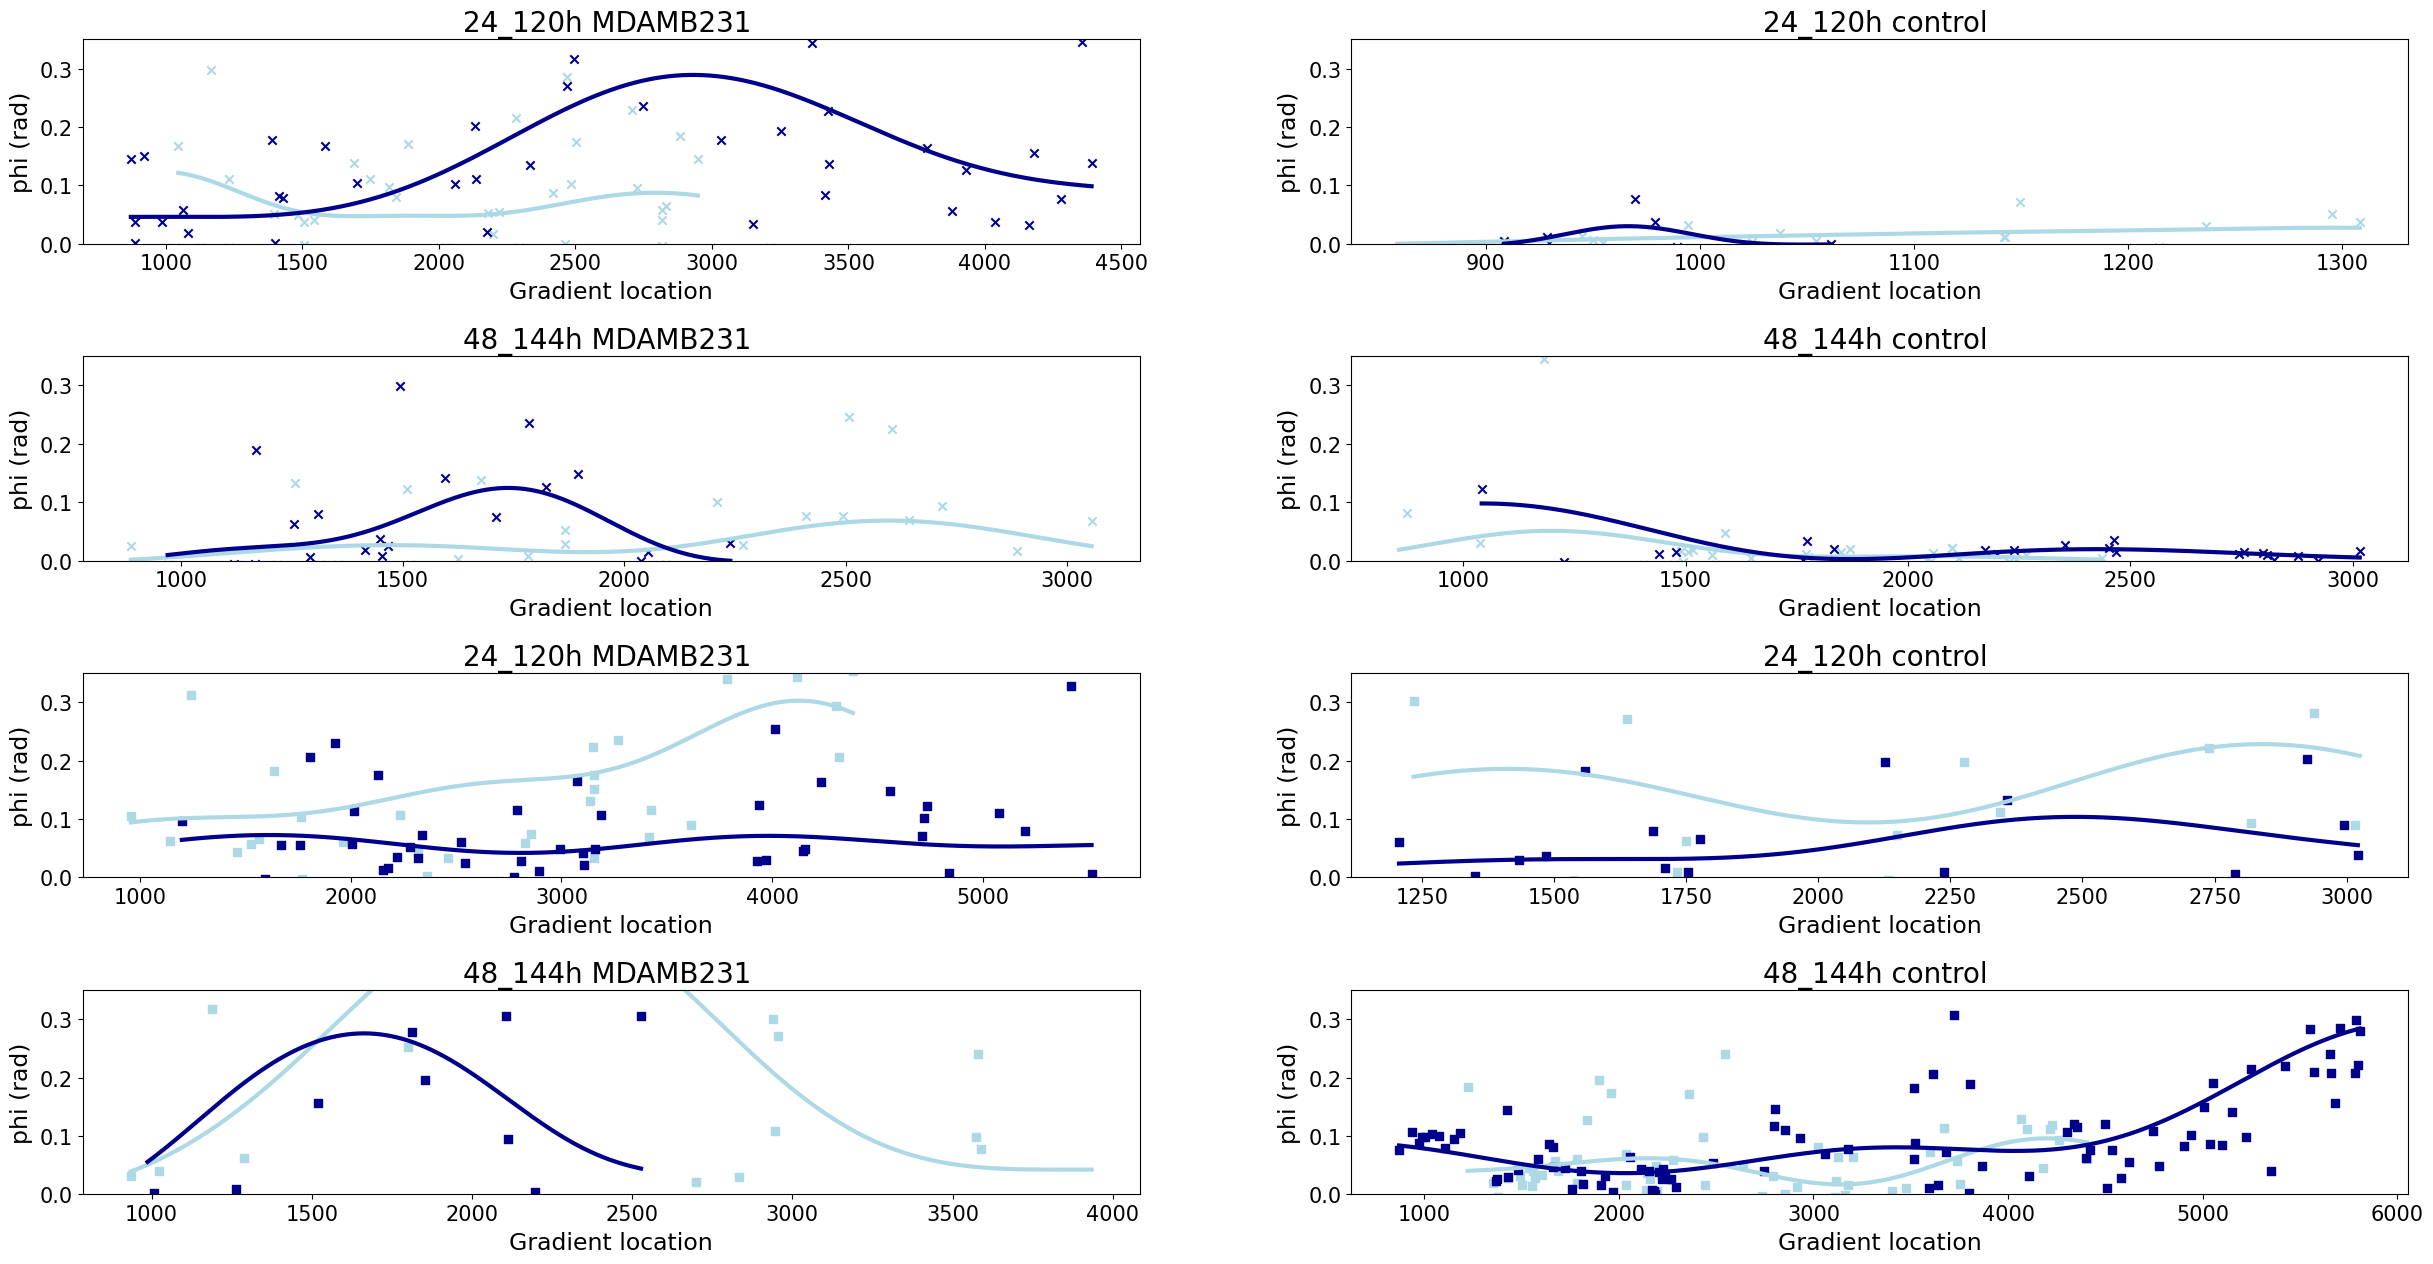

In [94]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = i+(2*k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)
                #print(dfffff)
                
                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    filtered_data = fourth[(fourth['gradient'] > fourth['gradient'].min()+800) & (fourth['gradient'] < fourth['gradient'].max()-800)]
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(filtered_data['gradient'],filtered_data['phi_(rad)'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    filtered_data = fourth[(fourth['gradient_inverse'] > fourth['gradient_inverse'].min()+800) & (fourth['gradient_inverse'] < fourth['gradient_inverse'].max()-800)]
                    fitting_kernel(filtered_data['gradient_inverse'],filtered_data['phi_(rad)'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("phi (rad)", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)


                ax.set_ylim (0,0.35) 
                # ax.set_xlim (0,5000)  
                
        print()
                

Text(0.5, 1.0, 'Control sample 24h')

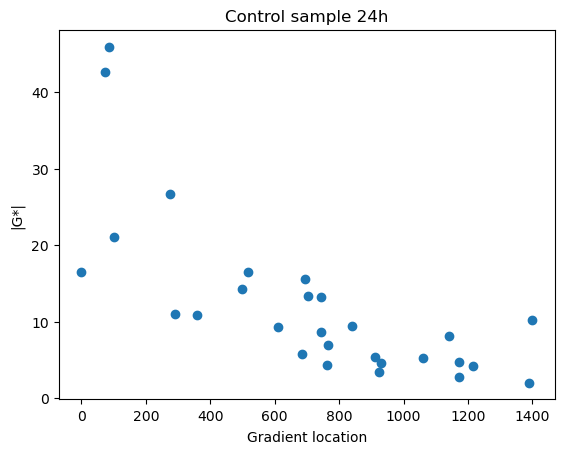

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')